Now after we see The score of some best model we have train 
The model I chose is Ensamble model From 3 model That made the best score 
now we should train these model on the whole data for better **score** and better **generalization**.

so this *Notebook* is just for showing the last step in the training.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sn
import re

import tensorflow as tf 
import tensorflow.keras as keras 

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics_model
import sklearn.linear_model as linear_model

In [8]:
import tensorflow_addons as tfa
f1=tfa.metrics.F1Score(5)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import re
def remove_just_Hash(data):
  data=re.sub('#','',data)
  return data

In [ ]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_just_Hash)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_just_Hash)

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values


#X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['NomericSentiment'],random_state=42)

y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
#y_val=keras.utils.to_categorical(y_val,5)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)


X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
#X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=70)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=70)
#X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=70)



45832


In [5]:
path='/content/drive/MyDrive/The_Best_model/'

In [6]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint(path+'GRU_With_Regulization.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
# reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
#   verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
#   min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/GRU_with_Regulaization_And_clean_#.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13749600  
_________________________________________________________________
gru (GRU)                    (None, 70, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,014,437
Trainable params: 14,014,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
X_train_set.shape,X_test_set.shape

((32912, 70), (8229, 70))

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=10,validation_data=(X_test_set,y_test),callbacks=callbacks_list)

Epoch 1/10
1029/1029 [==============================] - 265s 256ms/step - loss: 0.3751 - accuracy: 0.8740 - val_loss: 0.5764 - val_accuracy: 0.8016
Epoch 2/10
1029/1029 [==============================] - 267s 259ms/step - loss: 0.3467 - accuracy: 0.8858 - val_loss: 0.5646 - val_accuracy: 0.8120
Epoch 3/10
1029/1029 [==============================] - 266s 258ms/step - loss: 0.3241 - accuracy: 0.8914 - val_loss: 0.5745 - val_accuracy: 0.8048
Epoch 4/10
1029/1029 [==============================] - 268s 260ms/step - loss: 0.2982 - accuracy: 0.9024 - val_loss: 0.5697 - val_accuracy: 0.8091
Epoch 5/10
1029/1029 [==============================] - 265s 257ms/step - loss: 0.2240 - accuracy: 0.9281 - val_loss: 0.6725 - val_accuracy: 0.8036


In [12]:
LR_START = 0.0000001
LR_MIN = 0.000001
LR_MAX = 0.0008
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


In [ ]:
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint(path+'LSTM_with_regulization.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
# reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
#   verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
#   min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [ ]:
model_1=keras.models.load_model('/content/drive/MyDrive/LSTM_with_Regulaization_And_clean_#.h5')

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_1.fit(X_train_set,y_train,epochs=10,validation_data=(X_test_set,y_test),callbacks=callbacks_list)

Epoch 1/10
1029/1029 [==============================] - 279s 269ms/step - loss: 0.3510 - accuracy: 0.8905 - f1_score: 0.8955 - val_loss: 0.6591 - val_accuracy: 0.7886 - val_f1_score: 0.7964
Epoch 2/10
1029/1029 [==============================] - 283s 275ms/step - loss: 0.3393 - accuracy: 0.8918 - f1_score: 0.8964 - val_loss: 0.6284 - val_accuracy: 0.7966 - val_f1_score: 0.8032
Epoch 3/10
1029/1029 [==============================] - 284s 276ms/step - loss: 0.3192 - accuracy: 0.8989 - f1_score: 0.9027 - val_loss: 0.6763 - val_accuracy: 0.7809 - val_f1_score: 0.7878
Epoch 4/10
1029/1029 [==============================] - 286s 278ms/step - loss: 0.2972 - accuracy: 0.9047 - f1_score: 0.9083 - val_loss: 0.6829 - val_accuracy: 0.7873 - val_f1_score: 0.7932
Epoch 5/10
1029/1029 [==============================] - 286s 278ms/step - loss: 0.2432 - accuracy: 0.9244 - f1_score: 0.9274 - val_loss: 0.7080 - val_accuracy: 0.7864 - val_f1_score: 0.7918


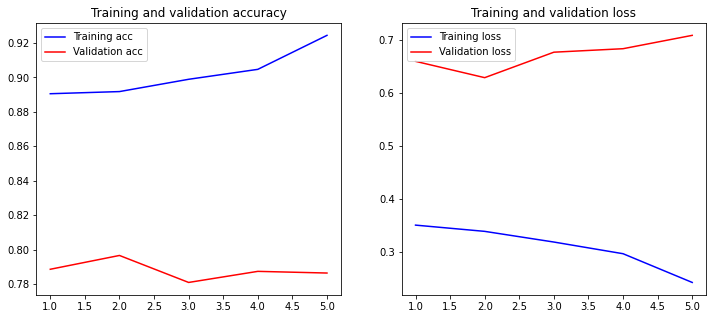

In [ ]:
plot_history(history)

In [ ]:
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint(path+'GRU_with_Learning_scheduler.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
# reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
#   verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
#   min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [ ]:
model_2=keras.models.load_model('/content/drive/MyDrive/GRU_Learning_scheduler.h5')
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           13749600  
_________________________________________________________________
gru (GRU)                    (None, 60, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,014,437
Trainable params: 14,014,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  history=model_2.fit(X_train_set[:,:-10],y_train,epochs=10,validation_data=(X_test_set[:,:-10],y_test),callbacks=callbacks_list)

Epoch 1/10
1029/1029 [==============================] - 138s 133ms/step - loss: 0.3196 - accuracy: 0.8951 - val_loss: 0.6041 - val_accuracy: 0.7907
Epoch 2/10
1029/1029 [==============================] - 141s 137ms/step - loss: 0.2984 - accuracy: 0.9023 - val_loss: 0.5722 - val_accuracy: 0.8034
Epoch 3/10
1029/1029 [==============================] - 137s 133ms/step - loss: 0.2549 - accuracy: 0.9161 - val_loss: 0.5899 - val_accuracy: 0.8025
Epoch 4/10
1029/1029 [==============================] - 138s 134ms/step - loss: 0.2171 - accuracy: 0.9275 - val_loss: 0.6692 - val_accuracy: 0.7954
Epoch 5/10
1029/1029 [==============================] - 138s 134ms/step - loss: 0.1460 - accuracy: 0.9535 - val_loss: 0.7352 - val_accuracy: 0.7926


In [10]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_just_Hash)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_just_Hash)

dic={0:0,1:1,3:0,4:1}

train_set=train_set[train_set['NomericSentiment']!=2]
test_set=test_set[test_set['NomericSentiment']!=2]

train_set['label']=train_set['NomericSentiment'].apply(lambda x:dic[x])
test_set['label']=test_set['NomericSentiment'].apply(lambda x:dic[x])

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['label'].values
y_test=test_set['label'].values


#X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['label'],random_state=42)

# y_train=keras.utils.to_categorical(y_train,2)
# y_test=keras.utils.to_categorical(y_test,2)
# y_val=keras.utils.to_categorical(y_val,2)
y_train=y_train.astype(np.uint8)
y_test=y_test.astype(np.uint8)
#y_val=y_val.astype(np.uint8)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
#X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=70)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=70)
#X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=70)


40518


In [17]:
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint(path+'Binary_classification_2.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
# reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
#   verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
#   min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [14]:
model_1=keras.models.load_model('/content/drive/MyDrive/Binary_Classifaction.h5')
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           12155400  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,506,761
Trainable params: 12,506,761
Non-trainable params: 0
_________________________________________________________________


In [15]:
with tf.device('/device:GPU:0'):
  history=model_1.fit(X_train_set,y_train,epochs=20,validation_data=(X_test_set,y_test),batch_size=16,callbacks=callbacks_list)

Epoch 1/20
1673/1673 [==============================] - 455s 267ms/step - loss: 0.1452 - accuracy: 0.9472 - val_loss: 0.2725 - val_accuracy: 0.8937
Epoch 2/20
1673/1673 [==============================] - 455s 272ms/step - loss: 0.1405 - accuracy: 0.9498 - val_loss: 0.2771 - val_accuracy: 0.9003
Epoch 3/20
1673/1673 [==============================] - 467s 279ms/step - loss: 0.1327 - accuracy: 0.9526 - val_loss: 0.3111 - val_accuracy: 0.9025
Epoch 4/20
1673/1673 [==============================] - 465s 278ms/step - loss: 0.1260 - accuracy: 0.9572 - val_loss: 0.3203 - val_accuracy: 0.9040


In [16]:
model_2=keras.models.load_model('/content/drive/MyDrive/Binary_Classifaction_2.h5')
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           12155400  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,379,209
Trainable params: 12,379,209
Non-trainable params: 0
____________________________________________

In [18]:
with tf.device('/device:GPU:0'):
  history=model_2.fit(X_train_set,y_train,epochs=20,validation_data=(X_test_set,y_test),batch_size=16,callbacks=callbacks_list)

Epoch 1/20
1673/1673 [==============================] - 67s 40ms/step - loss: 0.1366 - accuracy: 0.9501 - val_loss: 0.2558 - val_accuracy: 0.8943
Epoch 2/20
1673/1673 [==============================] - 83s 50ms/step - loss: 0.1298 - accuracy: 0.9539 - val_loss: 0.2511 - val_accuracy: 0.9021
Epoch 3/20
1673/1673 [==============================] - 83s 50ms/step - loss: 0.1108 - accuracy: 0.9610 - val_loss: 0.3057 - val_accuracy: 0.8832
Epoch 4/20
1673/1673 [==============================] - 82s 49ms/step - loss: 0.0891 - accuracy: 0.9692 - val_loss: 0.3168 - val_accuracy: 0.9007
Epoch 5/20
1673/1673 [==============================] - 82s 49ms/step - loss: 0.0440 - accuracy: 0.9856 - val_loss: 0.3527 - val_accuracy: 0.9007
